In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import gudhi as gd
from utils import *
from utilsTopology import *
from utilsBaricentricNeuralNetwork import *
from tqdm import tqdm
import wfdb
import os

fontsize=16

Downloading the database

In [4]:
if os.path.isdir("mitdb"):
    print('You already have the data.')
else:
    wfdb.dl_database('mitdb', 'mitdb')

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

Reading and plotting a record

{'fs': 360, 'sig_len': 3000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V5'], 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']}


Text(0, 0.5, 'Lead II')

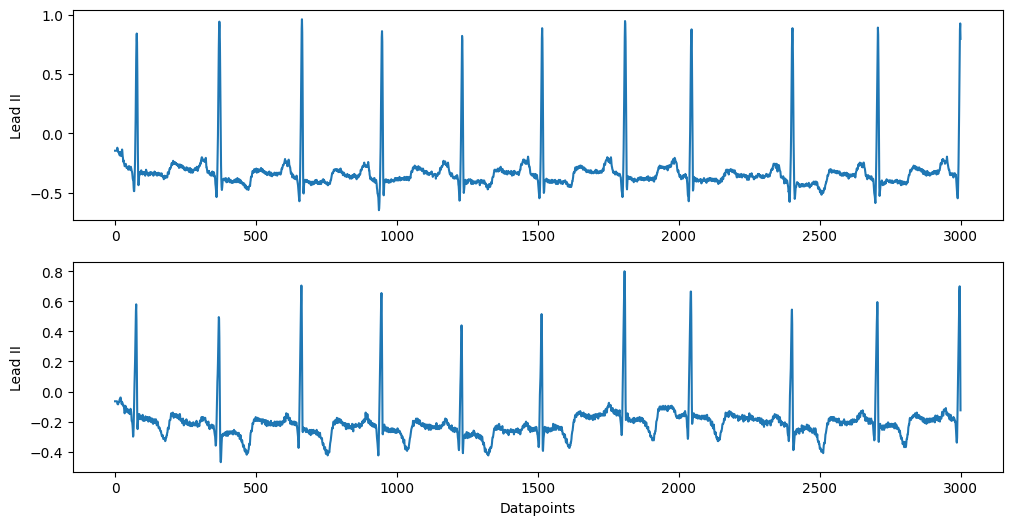

In [7]:
record = wfdb.rdsamp('mitdb/100', sampto=3000)
annotation = wfdb.rdann('mitdb/100', 'atr', sampto=3000)
print(record[1])
fig, ax = plt.subplots(nrows=2, figsize=(12,6))
I = record[0][:, 0]
II = record[0][:, 1]

ax[0].plot(I)
ax[1].plot(II)
ax[0].set_ylabel('Lead II')
ax[1].set_xlabel('Datapoints')
ax[1].set_ylabel('Lead II')

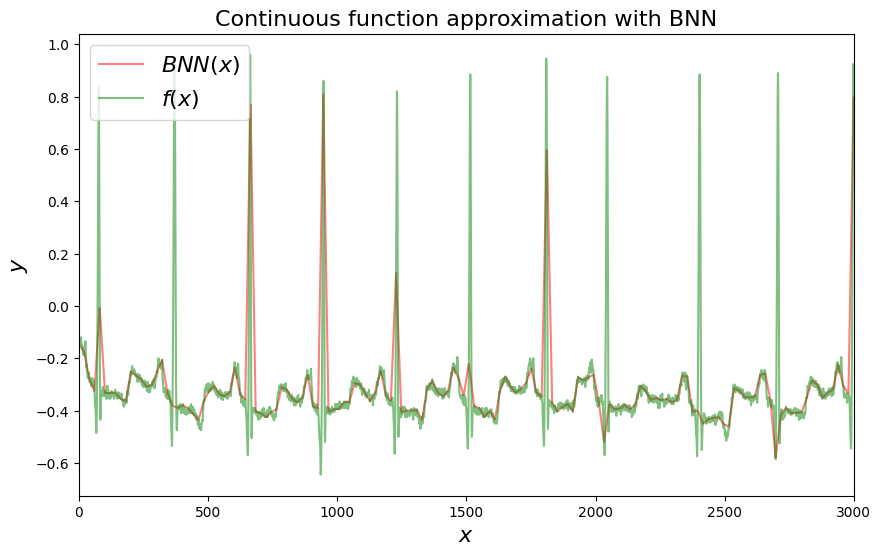

In [16]:
x_train, y_train = np.arange(0, len(I)), I
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

x_points = tf.Variable(tf.cast(tf.linspace(0,len(I)-1,150), dtype=tf.float32) ,trainable=True)
y_points = interpolation_tf(x_train,y_train, x_points)
points = tf.stack([x_points, y_points], axis=1)

model = BaricentricSigmaNetworkTf(points)
y_aprox = model(x_train)
    
plt.figure(figsize=(10, 6))
plt.plot(x_train, y_aprox, 'r-', label=f'$BNN(x)$', alpha=0.5)
plt.plot(x_train, y_train, 'g-', label=f'$f(x)$', alpha=0.5)
plt.xlabel('$x$', fontsize=fontsize)
plt.ylabel('$y$', fontsize=fontsize)
plt.xlim((0,len(I)))
plt.title(f'Continuous function approximation with BNN', fontsize = fontsize)
plt.legend(loc="upper left", fontsize=fontsize)
plt.show()

In [ ]:
x_train, y_train = np.arange(0, len(I)), I
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

domain=[0,len(I-1)]
stbase = gd.SimplexTree()
for i in range(len(I)-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]

entropyRef=persistent_entropy_tf(dgmRef)
entropyRefLim=persistent_entropy_lim_tf(dgmRef)

x_points = tf.Variable(tf.cast(tf.linspace(0,len(I)-1,150+2), dtype=tf.float32) ,trainable=True)
# y_points = tf.math.sin(x_points)
# points = tf.stack([x_points, y_points], axis=1)

min_diff_entropy = float('inf')
num_iter = 100  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$L_{PE_{lim}}$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points, y_points], axis=1)
        model = BaricentricSigmaNetworkTf(points)
        y_aprox = model(x_train)
        dgmsAprox = layer.call(y_aprox)
        dgmAprox = dgmsAprox[0][0]
        lossFunction = PersistentEntropyLossLimTF()
        entropyLoss = lossFunction(dgmRef,dgmAprox)

    
    dgmsAprox = layer.call(y_aprox)
    dgmAprox = dgmsAprox[0][0]
    entropyAproxActual=persistent_entropy_tf(dgmAprox)
    entropyAproxActualLim=persistent_entropy_lim_tf(dgmAprox)
    
    
    metricas["$L_{PE_{lim}}$"].append(entropyLoss.numpy().item())


    gradients = tape.gradient(entropyLoss,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [150 + 2 - 1]], [0.0, 0.0]) # we keep constant the two extrema points
    mseActual = tf.keras.losses.MSE(y_train,y_aprox)
    metricas["$MSE$"].append(mseActual.numpy().item())
    
    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_entropy = entropyAproxActual
        initial_entropyLim = entropyAproxActualLim

    
    if entropyLoss < min_diff_entropy:
        min_diff_entropy = entropyLoss
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_entropy = entropyAproxActual
        best_entropyLim = entropyAproxActualLim
    

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
        entropyAproxPrevio = entropyAproxActual
        msePrevio = mseActual
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_entropy = entropyAproxActual
        last_entropyLim = entropyAproxActualLim
        
    
metricasPE_wnoise  = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_entropy.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_entropy.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(x_train), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_entropy.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(entropyRef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.tight_layout()
plt.show()

 70%|███████   | 70/100 [03:33<01:39,  3.32s/it]